# 3.1 线性回归

In [1]:
%matplotlib inline
import math
import time
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [5]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [7]:
n = 10000
a = tf.ones([n])
b = tf.ones([n])
c = tf.Variable(tf.zeros(n))
timer = Timer()
for i in range(n):
    c[i].assign(a[i] + b[i])
f'{timer.stop():.5f} sec'

'7.33347 sec'

In [8]:
timer.start()
d = a + b
f'{timer.stop(): .5f} sec'

' 0.00100 sec'

In [12]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma ** 2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

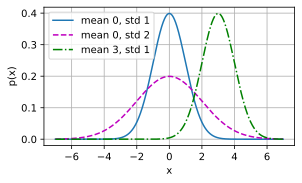

In [15]:
x = np.arange(-7, 7, 0.01)
# mu and sigma
params = [(0, 1), (0, 2), (3,1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', 
         figsize=(4.5,2.5), legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 3.2 线性回归从零开始实现

In [16]:
# 构造数据
def synthtic_data(w, b, num_examples):
    '''生成y=wx+b+noise'''
    x = tf.zeros((num_examples, w.shape[0]))
    x += tf.random.normal(shape=x.shape)
    y = tf.matmul(x, tf.reshape(w, (-1,1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1,1))
    return x,y
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthtic_data(true_w, true_b, 1000)

In [19]:
print('features:', features[0], 'labels:', labels[0])

features: tf.Tensor([ 2.1054592  -0.83702433], shape=(2,), dtype=float32) labels: tf.Tensor([11.279934], shape=(1,), dtype=float32)


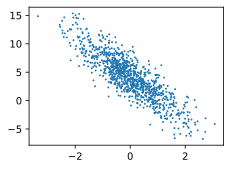

In [20]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [21]:
import random
def data_iter(batch_size, features, labels):
    '''读取数据集'''
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i:min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j) # 按照j对features做切片

In [22]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[ 1.076436   -0.5808394 ]
 [-0.5426087  -0.09432692]
 [-1.6739855  -0.20821595]
 [-0.338246   -2.4627013 ]
 [-0.9618714   1.3214358 ]
 [ 0.34196848  0.8309438 ]
 [ 1.7999799   0.9595505 ]
 [-0.3843159   1.5462534 ]
 [-0.738075   -0.60440326]
 [ 0.33839056 -0.38594243]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 8.338337 ]
 [ 3.4386027]
 [ 1.5715847]
 [11.880962 ]
 [-2.2148345]
 [ 2.066958 ]
 [ 4.539291 ]
 [-1.8116679]
 [ 4.778042 ]
 [ 6.184145 ]], shape=(10, 1), dtype=float32)


In [24]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01), trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

In [25]:
# 定义模型
def linreg(X, w, b):
    return tf.matmul(X, w) + b

In [26]:
# 定义损失函数
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape))**2 / 2

In [27]:
# 定义优化算法
def sgd(params, grads, lr, batch_size):
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

In [29]:
# 训练
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)
        dw, db = g.gradient(l, [w, b])
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epcoh: {epoch + 1}, loss:{float(tf.reduce_mean(train_l))}:f')

epcoh: 1, loss:5.067530582891777e-05:f
epcoh: 2, loss:5.067817255621776e-05:f
epcoh: 3, loss:5.070305633125827e-05:f


In [30]:
print(f'w的估计误差: {true_w - tf.reshape(w, true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: [ 0.00037503 -0.00053406]
b的估计误差: [-0.00017309]


# 3.3 线性回归的简洁实现

In [32]:
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [34]:
# 生成数据集
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, num_examples=1000)

In [35]:
# 读取数据集
def load_array(data_arrays, batch_size, is_train=True):
    '''构造迭代器
    is_train:是否在每个迭代周期将数据打乱
    '''
    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset  = dataset.batch(batch_size)
    return dataset
batch_size = 10
data_iter = load_array((features,labels), batch_size=batch_size)

In [38]:
next(iter(data_iter))

(<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
 array([[ 0.65877414,  0.05396835],
        [ 1.0527794 ,  1.1842372 ],
        [-0.34128618,  1.0428398 ],
        [ 1.4212224 , -0.16353802],
        [ 1.6201181 ,  0.83234847],
        [-1.4098719 , -1.2916749 ],
        [ 0.38838902,  2.0162525 ],
        [-0.54976207, -0.01538601],
        [-2.2728183 , -0.42852902],
        [-1.0607196 , -1.4246807 ]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1), dtype=float32, numpy=
 array([[ 5.3427534],
        [ 2.275214 ],
        [-0.0271338],
        [ 7.593068 ],
        [ 4.6276064],
        [ 5.7685966],
        [-1.8690455],
        [ 3.156852 ],
        [ 1.1005776],
        [ 6.9249773]], dtype=float32)>)

In [40]:
# 定义模型
initializer = tf.initializers.RandomNormal(stddev=0.01)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(1, kernel_initializer=initializer))

In [41]:
# 定义损失函数 loss
loss = tf.keras.losses.MeanSquaredError()

In [42]:
# 定义优化算法
trainer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [45]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for x,y in data_iter:
        with tf.GradientTape() as tape:
            l = loss(net(x, training=True), y)
        grads = tape.gradient(l, net.trainable_variables)
        trainer.apply_gradients(zip(grads, net.trainable_variables))
    l = loss(net(features), labels)
    print(f'epoch: {epoch+1}, loss: {l:f}')

epoch: 1, loss: 0.000311
epoch: 2, loss: 0.000103
epoch: 3, loss: 0.000102


In [49]:
w = net.get_weights()[0]
print('w的估计误差：', true_w - tf.reshape(w, true_w.shape))
b = net.get_weights()[1]
print('b的估计误差：', true_b - b)

w的估计误差： tf.Tensor([-3.092289e-04  8.368492e-05], shape=(2,), dtype=float32)
b的估计误差： [0.00082874]


In [50]:
b

array([4.199171], dtype=float32)

# 3.5 图像分类数据集

In [2]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

In [3]:
# 读取数据集
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 3s 1us/step


In [4]:
len(mnist_train[0]), len(mnist_test[0])

(60000, 10000)

In [6]:
mnist_train[0][0].shape

(28, 28)

In [8]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [17]:
def show_images(imgs, num_rows, num_cols, title=None, scale=1.5):
    '绘制图像'
    figsize = (num_cols*scale, num_cols*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if title:
            ax.set_title(title[i])
    return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

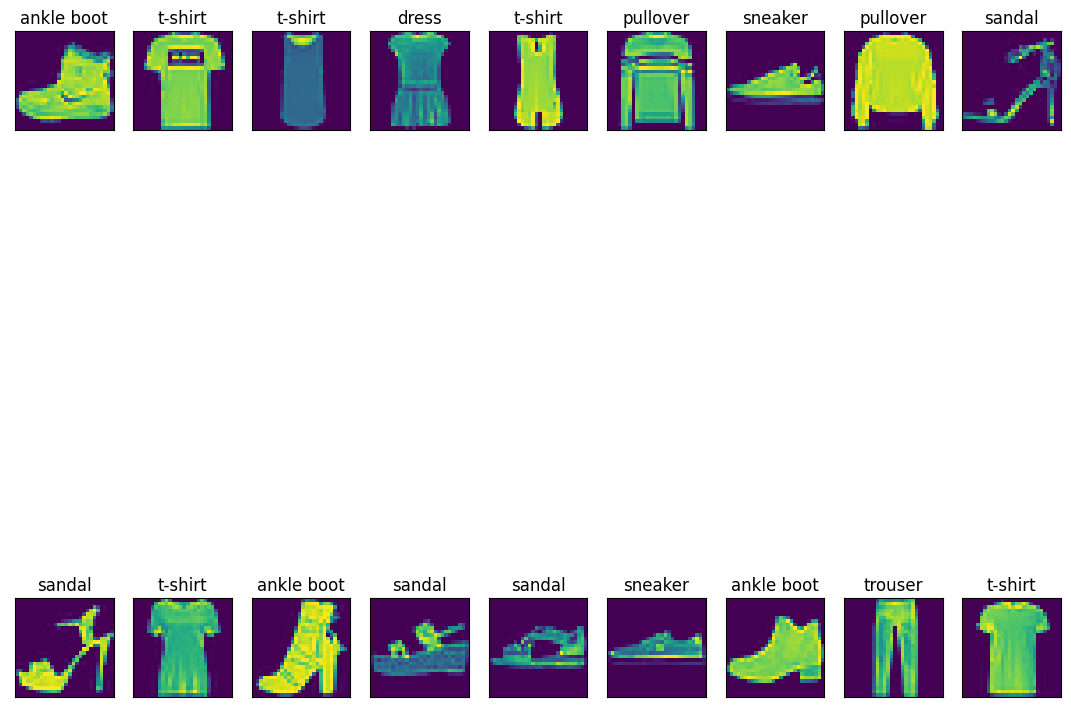

In [19]:
X = tf.constant(mnist_train[0][:18])
Y = tf.constant(mnist_train[1][:18])
show_images(X, 2, 9, title=get_fashion_mnist_labels(Y))

In [21]:
# batch size
batch_size = 256
train_iter = tf.data.Dataset.from_tensor_slices(
    mnist_train).batch(batch_size=batch_size).shuffle(len(mnist_train[0]))

In [23]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'0.20 sec'

In [24]:
def load_data_fashion_mnist(batch_size, resize=None):
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # 将所有数字除以255，使所有像素值介于0和1之间，在最后添加一个批处理维度，
    # 并将标签转换为int32。
    process = lambda X, y : (tf.expand_dims(X, axis=3)/255, tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y : (tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
            tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(batch_size).map(resize_fn))

In [25]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(32, 64, 64, 1) <dtype: 'float32'> (32,) <dtype: 'int32'>


# 3.6 softmax 回归从零开始实现

In [26]:
import tensorflow as tf
from IPython import display
from d2l import tensorflow as d2l

In [27]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [31]:
# 初始化模型参数
num_inputs = 784 # 28*28
num_outputs = 10
W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs), mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

In [32]:
# 定义 softmax 操作
x = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(x, 0, keepdims=True), tf.reduce_sum(x, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

In [33]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition

In [35]:
X = tf.random.normal((2,5), 0, 1)
softmax(X)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.09762233, 0.06145598, 0.3800194 , 0.13200556, 0.3288968 ],
       [0.09695429, 0.04933088, 0.72483915, 0.0293542 , 0.09952147]],
      dtype=float32)>

In [36]:
# 定义模型
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

In [38]:
# 定义损失函数
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0,2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

In [40]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))
cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

In [41]:
# 分类精度
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [42]:
accuracy(y_hat, y) / len(y)

0.5

In [43]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [44]:
# 对于任意 data_iter 计算精度
def evaluate_accuracy(net, data_iter):
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [45]:
evaluate_accuracy(net, test_iter)

0.0663

In [46]:
# 训练
def train_epoch_ch2(net, train_iter, loss, updater):
    metric = Accumulator(3)
    for X, y in test_iter:
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras内置的损失接受的是（标签，预测），这不同于用户在本书中的实现。
            # 本书的实现接受（预测，标签），例如我们上面实现的“交叉熵”
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_Variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        
        l_sum = l * float(tf.size(y)) if isinstance(loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    return metric[0] / metric[2], metric[1] / metric[2]

In [47]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [48]:
class Updater():  #@save
    """用小批量随机梯度下降法更新参数"""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

In [49]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch2(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

AssertionError: 0.5727818721532821

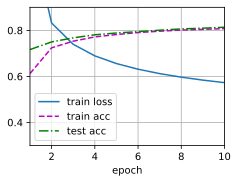

In [50]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

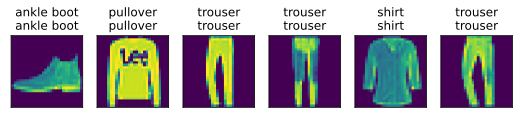

In [51]:
# 预测
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# 3.7 softmax 的简洁实现

In [53]:
import tensorflow as tf
from d2l import tensorflow as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [54]:
# 初始化模型
net = tf.keras.models.Sequential()
net.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
net.add(tf.keras.layers.Dense(10, kernel_initializer=weight_initializer))

In [55]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [56]:
trainer = tf.keras.optimizers.SGD(learning_rate=0.1)

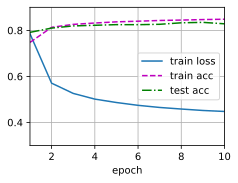

In [57]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)